# Single Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
import pandas as pd
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd


from radar_plot import radar_factory, normalize
from algorithms_single import *

In [2]:
df = pd.read_csv('../MFP Regular Sites 2019 - addresses2019 updated.csv')

In [3]:
df.columns

Index(['Site Name', 'Address', 'City', 'State', 'ZIP', 'latitude', 'longitude',
       'Number of Visits in 2019', 'Average Demand per Visit',
       'StDev(Demand per Visit)', 'Unnamed: 10',
       'Demand per Visit == the number of clients serviced on that visit'],
      dtype='object')

In [4]:
locations = df[['latitude', 'longitude']]
weights = df['Average Demand per Visit']
stdev = df['StDev(Demand per Visit)']

In [5]:
np.random.normal([0,1], [1,5])

array([-0.58739037,  3.47674891])

### Scaling with n

In [14]:
data = []

algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d: hope_guardrail(a,b,c,d,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d: hope_guardrail(a,b,c,d,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full
            }

num_iterations = 10000
max_n = len(stdev)

print(max_n)

# for n in tqdm(np.arange(1, max_n+1, 1000)):

num_groups = np.arange(5, max_n)

for n in tqdm(num_groups):
    
    
    
    alloc_diff = np.zeros((len(algo_list), n, num_iterations))

    
    for i in range(num_iterations):
        index = np.random.choice(max_n, n, replace=False)
        mean_size = weights[index]
        stdev_size = stdev[index]
        
        
        budget = np.sum(mean_size)
        
        size = np.maximum(1, np.random.normal(mean_size, stdev_size))
        # print(size)
        # size = 1+np.random.poisson(size=n,lam = mean_size-1)
        # size = 1 + np.random.normal(size=n, loc = mean_size - 1, scale=.1)
        index = 0        

        opt = offline_opt(budget, size, mean_size, stdev_size)

        for algo in algo_list:
            sol = algo_list[algo](budget, size, mean_size, stdev_size)

            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'L1', 'Value': np.sum(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Linf', 'Value': np.max(np.abs(opt-sol))}
            data.append(data_dict)
            alloc_diff[index, :, i] = opt - sol
            if np.around(budget - np.dot(size, sol), 3) < 0:
                print('ERROR: ' + str(algo))
                print(np.dot(size, sol), budget)

            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Waste', 'Value': (budget - np.dot(size, sol))}
            data.append(data_dict)

            index += 1

    index = 0
    for algo in algo_list:
        data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Ex-Ante Envy', 'Value': np.max(np.mean(np.abs(alloc_diff[index, :, :]), axis=1))}
        data.append(data_dict)
        index += 1

    
    
    

70


  0%|          | 0/65 [00:00<?, ?it/s]

In [15]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data/single_fbst.csv', index=False)
df = pd.read_csv('./data/single_fbst.csv')

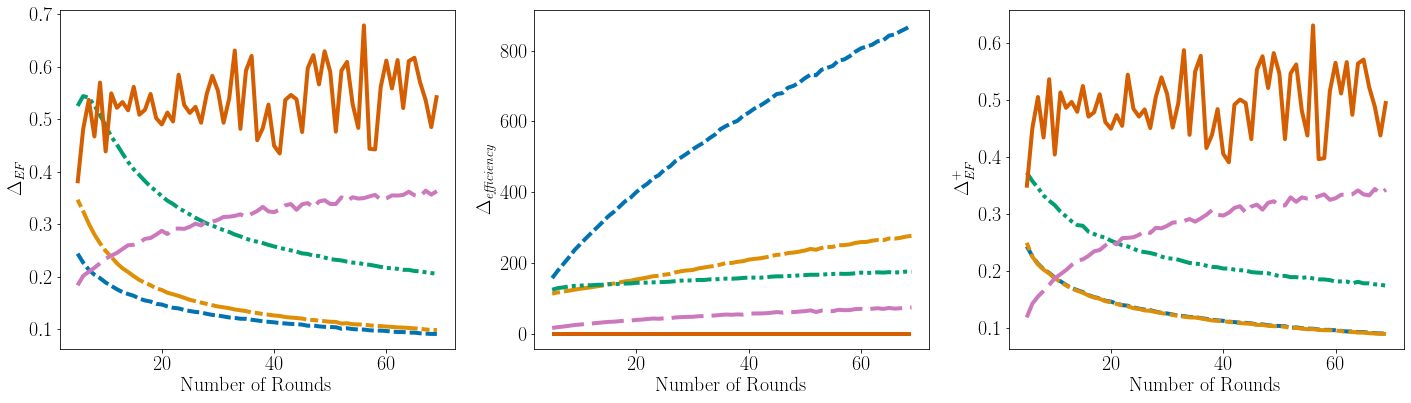

In [16]:

df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Fixed Threshold', 'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))



plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Linf'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Ex-Ante Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)



axs[0].get_legend().remove()
axs[0].set_ylabel('$\Delta_{\it EF}$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\Delta_{\it efficiency}$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\Delta_{\it EF}^+$')
axs[2].set_xlabel('Number of Rounds')


# axs[2].legend(ncol = 1, loc= 'upper right')




plt.show()
fg.savefig('./figures/fbst_single.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)

### Group by Group Difference

In [9]:
fair_data = []
loc_data = []


n = 50
num_iterations = 200


alloc_diff = np.zeros((len(algo_list), n, num_iterations))



for i in tqdm(range(num_iterations)):
    

    index = np.random.choice(max_n, n, replace=False)
    expected_size = weights[index]
    stdev_size = stdev[index]


    budget = np.sum(expected_size)

    size = np.maximum(1, np.random.normal(expected_size, stdev_size))
    index = 0
    opt = offline_opt(budget, size, expected_size, stdev_size)
    for algo in algo_list:
        sol = algo_list[algo](budget, size, expected_size, stdev_size)
        
        
        alloc_diff[index, :, i] = opt - sol
        index += 1
        for j in range(n):
            loc_data.append({'Location':j, 'Algorithm':algo, 'Value': opt[j] - sol[j]})
        nsw = (np.prod(np.power(np.asarray(sol), np.asarray(size))))**(1 / np.sum(size))
        fair_data.append({'Iteration':i, 'Algorithm':algo, 
                          '$\Delta_{\it efficiency}$':(budget - np.dot(size, sol)), 
                           
                          '$\Delta_{\it Prop}$':((budget / np.sum(size)) - np.min(sol)),
                         '\textsc{NSW}'.encode('unicode_escape').decode('utf'): nsw,
                         '\textsc{Envy}'.encode('unicode_escape').decode('utf'):(np.max(sol) - np.min(sol)), 
                          '$\Delta_{\it EF}$': np.max(np.abs(sol-opt))
                         
                         }) 
    
            
    for i in range(n):
        loc_data.append({'Location': i, 'Algorithm':'Zero', 'Value': 0})
                         

index = 0
for algo in algo_list:
    data_dict = {'Algorithm':algo, '$\Delta_{\it EF}^+$': np.max(np.mean(np.abs(alloc_diff[index, :, :]), axis=1))}
    fair_data.append(data_dict)
    index += 1

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
fair_df = pd.DataFrame.from_records(fair_data)

fair_df.to_csv('./data/single_fbst_fair.csv', index=False)
fair_df = pd.read_csv('./data/single_fbst_fair.csv')

Note: Discrepancy is between where max and average are between this plot and the other one.

### Printing Fairness Metrics

In [11]:
fair_df = fair_df.groupby(['Algorithm']).mean()

fair_df = fair_df.drop(['Iteration'], axis=1)
print(fair_df)


fair_df['$\Delta_{\it efficiency}$'] = (-1)*fair_df['$\Delta_{\it efficiency}$']
fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')] = (-1)*fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')]
fair_df['$\Delta_{\it EF}$'] = (-1)* fair_df['$\Delta_{\it EF}$']
fair_df['$\Delta_{\it Prop}$'] = (-1) * fair_df['$\Delta_{\it Prop}$']
fair_df['$\Delta_{\it EF}^+$'] = (-1)*fair_df['$\Delta_{\it EF}^+$']

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                          7.315883e+02             0.104294   
Hope Full                                6.707224e+01             0.322958   
Hope Guardrail $L_T = 1/2$               2.393176e+02             0.104294   
Hope Guardrail $L_T = 1/3$               1.642236e+02             0.107542   
Hope Online                             -1.182343e-13             0.136072   

                            \textsc{NSW}  \textsc{Envy}  $\Delta_{\it EF}$  \
Algorithm                                                                    
Fixed Threshold                 0.324503       0.000000           0.104294   
Hope Full                       0.825429       0.348386           0.323265   
Hope Guardrail $L_T = 1/2$      0.961408       0.147956           0.111162   
Hope Guardrail $L_T = 1/3$      0.965730       0.337912        

In [12]:
fair_df = normalize(fair_df)# .drop(['$\Delta_{\it Prop}$'], axis=1)
print(fair_df)

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                              0.100000             1.000000   
Hope Full                                    0.917488             0.100000   
Hope Guardrail $L_T = 1/2$                   0.705591             1.000000   
Hope Guardrail $L_T = 1/3$                   0.797972             0.986632   
Hope Online                                  1.000000             0.869206   

                            \textsc{NSW}  \textsc{Envy}  $\Delta_{\it EF}$  \
Algorithm                                                                    
Fixed Threshold                 0.100000       1.000000           1.000000   
Hope Full                       0.767383       0.404760           0.419356   
Hope Guardrail $L_T = 1/2$      0.948548       0.747208           0.981790   
Hope Guardrail $L_T = 1/3$      0.954306       0.422655        

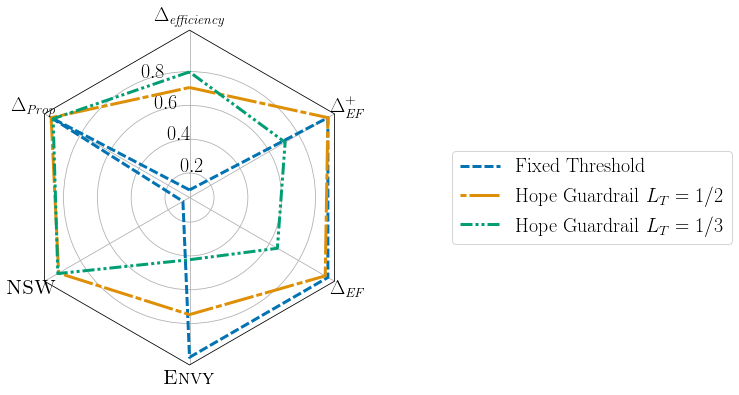

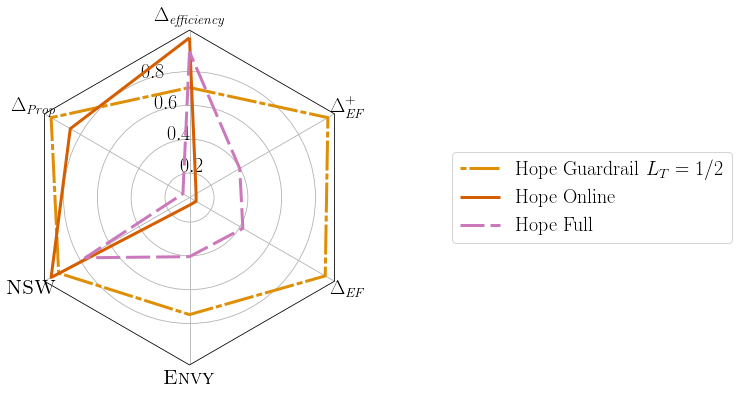

In [17]:
# number of variable


from math import pi
plt.style.use('PaperDoubleFig.mplstyle.txt')

plt.rc('text', usetex=True)




N = len(list(fair_df))
theta = radar_factory(N, frame='polygon')

spoke_labels = list(fair_df)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title('Comparison of Fairness Metrics',  position=(0.5, 1.1), ha='center')
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]

first_plot = { algo : algo_list[algo] for algo in ['Fixed Threshold', 'Hope Guardrail $L_T = 1/2$', 'Hope Guardrail $L_T = 1/3$']}
second_plot = { algo : algo_list[algo] for algo in ['Hope Guardrail $L_T = 1/2$', 'Hope Online', 'Hope Full']}


index = 0
for algo in first_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = sns.color_palette('colorblind', len(algo_list))[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/single_fbst_guardrail_radar.pdf')
plt.show()





fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])


dashesStyles = [
            [2,1,10,1],
            [1000,1],[8,2]]

color_list = [sns.color_palette("colorblind", len(algo_list))[1], sns.color_palette("colorblind", len(algo_list))[3], sns.color_palette("colorblind", len(algo_list))[4]]

index = 0
for algo in second_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = color_list[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/single_fbst_heuristic_radar.pdf')
plt.show()


